In [1]:
#gerekli kütüphaneler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report

In [2]:
#sürüm içi hataları görmezden gel

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

## Veriyi Okumak ve Veri Kümesinin İlk 8 Satırının İncelenmesi:

In [3]:
df=pd.read_csv("winequality.csv")
df.head(8)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7


## Veri Eksik Değer Kontrolü

In [4]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

## Verinin Sahip Olduğu 12 Farklı Değişkene Ait İçerik Tablosu

In [5]:
df.describe().T  

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


## Veri İçerik Tablosunun Yorumlanması

Veri üzerine uyguladığımız desribe() fonksyionu yardımıyla elde ettigimiz degerler üzerinden kısa yorumlamalar yapalım;

* Verinin tüm degiskenleri esit miktarda girdiye sahiptir. Yani her degisken 1599 adet girdi içermektedir.
* Serbest sülfür dioksit miktarının ortalaması 15,9 civarı seyrederken toplam sülfür dioksit miktarının ortalaması 46,5 civarında seyretmektedir.
* Şarap kalitesine verilen kategorik değerler veri setinde 3-8 arasında ilerlemektedir.
* Elimizdeki şarap verisi üzerinde gözlemlene x şarabının minimum pH'ı 2.74 iken maksimum pH 4.01 olarak gözlemlenir. 
* Tüm veri setinin sahip oldugu farklı kalitedeki şarapların pH ortalaması 3.31 olarak gözlemlenir.

## Farklı Sınıflandırma Algoritmalarıyla Şarap Kalitesi Belirleme:

In [6]:
#Şarap kalitesini iyi ve kötü olmak üzere 0-1 olarak degerlendirme
#Kalite durumu quality sütununun ortalaması baz alınarak 0-1 şeklinde ayrılmıştır

df['quality_level'] = [1 if x >= 5.63 else 0 for x in df['quality']]

Verimizde kalite ölçütü olarak verilen değerler 3,4,5,6,7,8 olarak gitmektedir. 
Öncelikle uyguladığımız algoritmalar üzerinde ilk haline göre,ardından da kalite değerleri için ayrı bir label encode oluşturarak ölçüt sayısını daha aza indirip bunun bize fayda sağlayıp sağlamadığını incelemiş olalım.

In [7]:
X=df.iloc[:,:10]
y=df.iloc[:,12]

* X --> Bağımsız değişkenlerimizi temsil eder. 
* Şarap kalitesine karar vermek için bize verilmiş olan 10 farklı özellik üzerinden
bağımlı değişkenimiz olan y'yi yani şarap kalitesini belirlemeye çalışacağız. Bunun için farklı test,train oranını belirleyip ardından sınıflandırma algoritmaları kullanacağız.

In [8]:
#Train-Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.45,random_state=42)

## LOJİSTİK REGRESYON UYGULAMASI VE ALGORİTMA İYİLEŞTİRME

In [9]:
#lojistik regresyon uygulaması
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver = "liblinear")
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

In [10]:
print ("Accuracy: %.3f" % accuracy_score(y_test, y_pred))

Accuracy: 0.682


In [11]:
print ("Classification Report Results")
print (classification_report(y_test, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False))

Classification Report Results
              precision    recall  f1-score   support

           0       0.72      0.55      0.62       423
           1       0.66      0.81      0.72       457

    accuracy                           0.68       880
   macro avg       0.69      0.68      0.67       880
weighted avg       0.69      0.68      0.68       880



In [12]:
#lojistik regresyon için GridSearchCV ile en iyi parametre seçimi yaparak accuracy skor iyileştirme

from sklearn.model_selection import GridSearchCV
param=[{'penalty':["l1", "l2", "elasticnet", "none"],'solver':["newton-cg", "lbfgs", "liblinear", "sag", "saga"]}]
gs=GridSearchCV(estimator=log_reg,param_grid=param,scoring='accuracy',cv=10,n_jobs=-1,verbose=2).fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 185 out of 200 | elapsed:    2.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.9s finished


In [13]:
bestresult=gs.best_score_
bestparameters=gs.best_params_
print(bestparameters,"en iyi parametrelerdir.")

{'penalty': 'none', 'solver': 'newton-cg'} en iyi parametrelerdir.


In [14]:
#iyilestirilmis lojistik regresyon sonucu

log_reg_tuned = LogisticRegression(solver = "newton-cg",penalty="none")
log_reg_tuned.fit(X_train, y_train)
y_pred = log_reg_tuned.predict(X_test)
print ("İyileştirilmiş algoritmanın accuracy değeri: %.3f" % accuracy_score(y_test, y_pred))

İyileştirilmiş algoritmanın accuracy değeri: 0.706


- GridSearchCV yardımıyla Lojistik Regresyon için uygun olan en iyi parametreleri belirleyerek accuracy skorumuzu 0.68'den 0.71'e çıkarmış olduk.

## XGBOOST UYGULAMASI VE ALGORİTMA İYİLEŞTİRME

In [15]:
!pip install xgboost
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)

In [16]:
print ("Accuracy: %.3f" % accuracy_score(y_test, y_pred))

Accuracy: 0.728


In [17]:
print ("Classification Report Results")
print (classification_report(y_test, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False))

Classification Report Results
              precision    recall  f1-score   support

           0       0.74      0.68      0.71       423
           1       0.72      0.77      0.75       457

    accuracy                           0.73       880
   macro avg       0.73      0.73      0.73       880
weighted avg       0.73      0.73      0.73       880



Görüldüğü üzere XGboost bazı ufak parametrelerle Lojistik Regresyonla elde edilen sonucu çok rahat bi şekilde elde etti.
O halde GSCV ile en iyi parametreleri de bulmayı deneyerek acc. score ne kadar yükselebilir bulmaya çalışalım.

In [18]:
#xgboost algoritmasını en iyi parametreleri belirleyerek iyileştirme 

params = {"n_estimators": [500, 725,250,800],
             "subsample":[0.6,0.8],
             "max_depth":[5,7],
             "learning_rate":[0.1]}

In [19]:
xgb_gs = GridSearchCV(xgb, params, cv = 10, 
                            n_jobs = -1, verbose = 2).fit(X_train, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   23.8s finished


In [20]:
bestresult=xgb_gs.best_score_
bestparameters=xgb_gs.best_params_
print(bestparameters,"en iyi parametrelerdir.")

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250, 'subsample': 0.6} en iyi parametrelerdir.


In [21]:
xgb_tuned = XGBClassifier(learning_rate=0.1, max_depth =5, n_estimators = 250, subsample = 0.6)
xgb_tuned.fit(X_train,y_train)
y_pred = xgb_tuned.predict(X_test)
print ("İyileştirilmiş algoritmanın accuracy değeri: %.3f" % accuracy_score(y_test, y_pred))

İyileştirilmiş algoritmanın accuracy değeri: 0.735


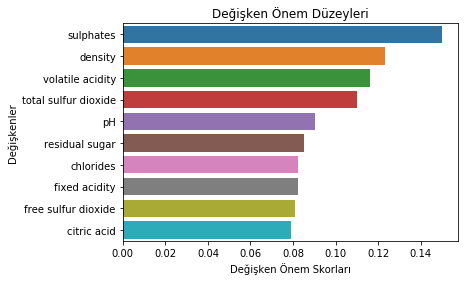

In [22]:
#xgboosta göre degiskenlerin önem düzeyleri

import seaborn as sns
feature_imp = pd.Series(xgb_tuned.feature_importances_,
                        index=X_train.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Değişken Önem Skorları')
plt.ylabel('Değişkenler')
plt.title("Değişken Önem Düzeyleri")
plt.show()

## RANDOM FOREST UYGULAMASI VE ALGORİTMA İYİLEŞTİRME

In [23]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred=rfc.predict(X_test)

In [24]:
print ("Accuracy: %.3f" % accuracy_score(y_test, y_pred))

Accuracy: 0.749


In [25]:
print ("Classification Report Results")
print (classification_report(y_test, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False))

Classification Report Results
              precision    recall  f1-score   support

           0       0.76      0.70      0.73       423
           1       0.74      0.79      0.77       457

    accuracy                           0.75       880
   macro avg       0.75      0.75      0.75       880
weighted avg       0.75      0.75      0.75       880



In [26]:
#random forest algoritmasının GSCV ile en iyi parametrelerini bulma

params=[{'n_estimators':[1,2,3,4,5,6,7,8,9,10],'criterion':['entropy']}]
rfc_gs = GridSearchCV(rfc, params, cv = 10, 
                            n_jobs = -1, verbose = 2).fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished


In [27]:
bestresult=rfc_gs.best_score_
bestparameters=rfc_gs.best_params_
print(bestparameters,"en iyi parametrelerdir.")

{'criterion': 'entropy', 'n_estimators': 10} en iyi parametrelerdir.


In [28]:
#random forest algoritmasının iyileştirilmesi

from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(criterion="entropy",n_estimators=8)
rfc.fit(X_train,y_train)
y_pred=rfc.predict(X_test)

In [29]:
print ("İyileştirilmiş algoritmanın accuracy değeri: %.3f" % accuracy_score(y_test, y_pred))

İyileştirilmiş algoritmanın accuracy değeri: 0.747


Görüldüğü üzere iyileştirmeler her zaman değer yükseltemeyebilir. Bazen ham olarak elde edilen sonuç daha yüksek olabilir. 
Şimdiye kadar elde ettiğimiz en yüksek değer Random Forest algoritması ile 0.74 oldu.

In [30]:
print ("Classification Report Results")
print (classification_report(y_test, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False))

Classification Report Results
              precision    recall  f1-score   support

           0       0.74      0.73      0.73       423
           1       0.75      0.76      0.76       457

    accuracy                           0.75       880
   macro avg       0.75      0.75      0.75       880
weighted avg       0.75      0.75      0.75       880



## SVM UYGULAMASI VE ALGORİTMA İYİLEŞTİRME

SVM icin değerlerin standardizasyonu gerekir.O nedenle öncelikle standart scale kullanıyoruz.

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [32]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Standardizasyon sonrası SVM sınıflandırıcısını uygulayabiliriz.

In [33]:
from sklearn.svm import SVC
svm=SVC()
svm.fit(X_train,y_train)
y_pred=svm.predict(X_test)

In [34]:
print ("Accuracy: %.3f" % accuracy_score(y_test, y_pred))

Accuracy: 0.713


In [35]:
print ("Classification Report Results")
print (classification_report(y_test, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False))

Classification Report Results
              precision    recall  f1-score   support

           0       0.72      0.65      0.69       423
           1       0.71      0.77      0.73       457

    accuracy                           0.71       880
   macro avg       0.71      0.71      0.71       880
weighted avg       0.71      0.71      0.71       880



In [36]:
#svm algoritmasının GSCV ile en iyi parametrelerini bulma

params=[{'C':[1,10,100,1000],'kernel':['rbf'],'gamma':[1,0.50,0.01,0.001,0.2,0.020],'degree':[1,2,3,4,5]},
        {'C':[1,2,3,4,5],'kernel':['linear'],'gamma':[1,0.5,0.1,0.01,0.001,0.20,0.020],'degree':[1,2,3,4,5]}]
svm_gs=GridSearchCV(svm,params,cv = 10, n_jobs = -1, verbose = 2).fit(X_train, y_train)

Fitting 10 folds for each of 295 candidates, totalling 2950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 2935 out of 2950 | elapsed:   21.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 2950 out of 2950 | elapsed:   21.6s finished


In [37]:
bestresult=svm_gs.best_score_
bestparameters=svm_gs.best_params_
print(bestparameters,"en iyi parametrelerdir.")

{'C': 1, 'degree': 1, 'gamma': 0.2, 'kernel': 'rbf'} en iyi parametrelerdir.


In [38]:
from sklearn.svm import SVC
svm_tuned=SVC(C=1,degree=1,gamma=0.2,kernel="rbf")
svm_tuned.fit(X_train,y_train)
y_pred=svm_tuned.predict(X_test)

In [39]:
print ("Accuracy: %.3f" % accuracy_score(y_test, y_pred))

Accuracy: 0.716


In [40]:
print ("İyileştirilmiş algoritmanın accuracy değeri: %.3f" % accuracy_score(y_test, y_pred))

İyileştirilmiş algoritmanın accuracy değeri: 0.716


##### SVM'in iyileştirilmesi de çok fazla fark yaratmadı. Tüm denemelerin sonucunda en yüksek değeri Random Forest algoritması üzerinden elde ettik.

##### Sonuçlar şu şekilde;
##### Lojistik Regresyon ----> 0.682
##### İyileştirilmiş Loj. Reg ----> 0.706
##### XGBoost ----> 0.728
##### İyileştirilmiş XGBoost ----> 0.735
##### Random Forest ----> 0.749
##### İyileştirilmiş Random Forest ----> 0.747
##### SVM ----> 0.713
##### İyileştirilmiş SVM ----> 0.716
